In [1]:
import pandas as pd
import numpy as np
import nltk
import os
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.feature_selection import SelectKBest, chi2


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aom2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# df=pd.read_csv("nhs_all_2023_03_31.tsv",sep="\t")

In [3]:
# df

In [4]:
# df_bin=df.iloc[0:int(np.floor(df.shape[0]*0.7)),:]
# df_bin=df.iloc[np.floor(df.shape[0]*0.7),:]

In [5]:
# df_tes=df.iloc[int(np.floor(df.shape[0]*0.7))+1:,:]

In [6]:
for f in os.listdir("content"):
    print(f)

BinMLResultsada_tfidf_binmat.png
BinMLResultsgb_tfidf_binmat.png
BinMLResultsknn_tfidf_binmat.png
BinMLResultslr_tfidf_binmat.png
BinMLResultsnb_tfidf_binmat.png
BinMLResultsrf_tfidf_binmat.png
BinMLResultssvm_countvec_binmat.png
BinMLResultssvm_tfidf_binmat.png
final_testset.xlsx
final_trainset.xlsx


In [7]:
df_bin = pd.read_excel("content/final_trainset.xlsx")
df_bin['binary2_label'].value_counts()
df_test = pd.read_excel("content/final_testset.xlsx")
df_bin['ABSTRACT'] = df_bin['ABSTRACT'].apply(str.lower)
df_test['ABSTRACT'] = df_test['ABSTRACT'].apply(str.lower)

In [8]:
list(df_test['ABSTRACT'])

['all descriptions of the lambert-eaton syndrome are based on symptomatic patients. we incidentally encountered electromyographic evidence of this syndrome in a patient being studied for another reason. the patient had controlled hypothyroidism and smoked for 9 pack-years but never had symptoms of weakness or had evidence of cancer. detailed electrophysiological and serological evaluations were undertaken in this study. neuromuscular transmission tests were consistent with a presynaptic disorder. autoantibodies specific for p/q-type voltage-gated calcium channels (vgcc) were detected in the serum and persisted throughout 7 years of follow-up. multiple igg markers of thyrogastric autoimmunity also were detected. this demonstration of asymptomatic lambert-eaton syndrome persisting for 8 years provided novel insight into the natural history of the disorder. it is plausible that patients with a subclinical syndrome would have abrupt neuromuscular decompensation when challenged with medicat

In [12]:
def bin_model( model_type, vectortype, C=1, select_features=8150):
    # Vectorization
    vectorizer = TfidfVectorizer() if vectortype == "tfidf" else CountVectorizer()        
    X_train = vectorizer.fit_transform(df_bin['ABSTRACT'])
    y_train = df_bin['binary2_label']
    
    # Feature Selection
    selector = SelectKBest(score_func=chi2, k=select_features)
    X_train_sel = selector.fit_transform(X_train, y_train)
    
    # Get the mask of the selected features and their scores
    scores = selector.scores_
    feature_names = vectorizer.get_feature_names_out()
    selected_mask = selector.get_support()
    selected_features = feature_names[selected_mask]

    # Rank features
    all_features_scores = zip(feature_names, scores if scores is not None else [0] * len(feature_names))
    ranked_features = sorted(all_features_scores, key=lambda x: x[1] if x[1] is not None else 0, reverse=True)[:select_features]

    # Model Training
    model = {
        'nb': MultinomialNB(),
        'lr': LogisticRegression(max_iter=1000),
        'svm': LinearSVC(C=C),
        'knn': KNeighborsClassifier(n_neighbors=7),
        'rf': RandomForestClassifier(),
        'ada': AdaBoostClassifier(n_estimators=50),
        'gb': GradientBoostingClassifier(n_estimators=50)
    }.get(model_type, LinearSVC(C=C))

    model.fit(X_train_sel, y_train)
    print('Training Accuracy:', model.score(X_train_sel, y_train))

    # Applying the same transformation to the test data
    X_test = vectorizer.transform(df_test['ABSTRACT'])
    X_test_sel = selector.transform(X_test)
    y_test = df_test['binary2_label']
    y_pred = model.predict(X_test_sel)

    # Evaluation
    print('Test Accuracy:', accuracy_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred, average="macro"))
    print('Precision:', precision_score(y_test, y_pred, average="macro"))
    print('Recall:', recall_score(y_test, y_pred, average="macro"))

    # Confusion Matrix Plot
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                        title="Binary Confusion Matrix",
                                        ax=ax1)
    plt.savefig('content/BinMLResults' + model_type + '_' + vectortype + '_binmat.png')

    return {
        'X_train_sel': X_train_sel,
        'y_train': y_train,
        'feature_names': feature_names,
        'selected_features': selected_features,
        'ranked_features': ranked_features,
        'y_pred': y_pred
    }


C:\Users\aom2\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.9337288563494067
Test Accuracy: 0.8004807692307693
F1 score: 0.7904536489151874
Precision: 0.8043061718434852
Recall: 0.7853225539559843


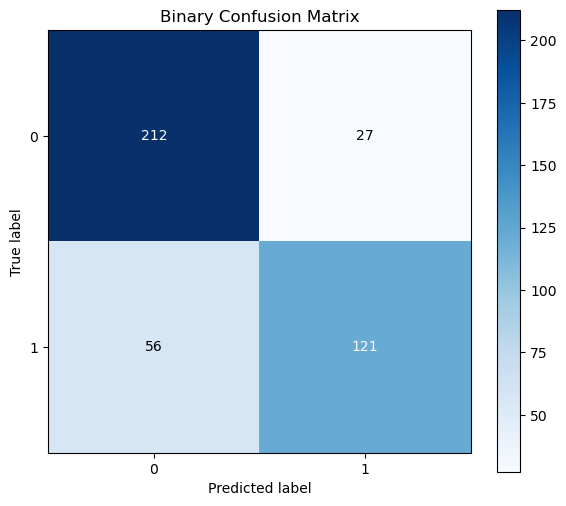

In [13]:
module_result_1=bin_model('svm', 'tfidf',C=1)

In [20]:
features_rank=pd.DataFrame(module_result_1['ranked_features'],columns=["features","weight"])

In [21]:
features_rank.to_csv("ML_Basic_Binary_Models_feature_selection-rank-features.csv")

In [17]:
 module_result_1['X_train_sel'].shape

(7922, 8150)